# Moment Invariants
In this file, we will try to implement to our dataset what we learned about Hu's Moments

In [1]:
# Sometimes the cv2 package is not available and has to be installed again
# ! pip install opencv-python

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We load up our dataset, that we already discussed about on the previous file.

In [3]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In order to calculate Hu's Moments, we need a binarized version of the images we have stored in the .npy file "X".

There are two main ways that we can use to achieve those transformations:
1. Transforming the colored image to greyscale, and then applying a threshold to make it binary.
2. Get the contour of the image, by generating a mask with cv2.

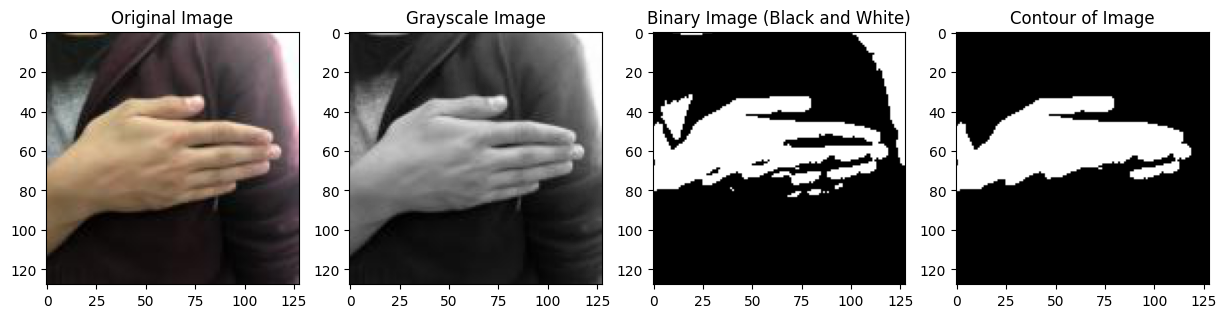

In [4]:
# Loading an example
test_image = X[9]

# First, we go with binary.
gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
gray_image_rescaled = np.uint8(gray_image * 255)

_, binary_image = cv2.threshold(gray_image_rescaled, 128, 255, cv2.THRESH_BINARY)

# Second, we go with contour.
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the largest contour.
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(binary_image)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_image)
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(gray_image_rescaled, cmap='gray')
plt.title('Grayscale Image')

plt.subplot(1, 4, 3)
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=255)  # Ensure correct color display
plt.title('Binary Image (Black and White)')

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
plt.title('Contour of Image')

plt.show()


We can see that the binary version and the contour actually yield seemingly different results, so it might be a good idea to consider both.

# Hu's Moments
We are going to be more meticulous with the binary case now, and the contour case follows from there, with slight differences.

## First Approach: Binary

From cv2 it is fairly straightforward to calculate the moments of an image:

In [5]:
B_moments = cv2.moments(binary_image)
for i, key in enumerate(B_moments):
    print(f"{key} : {B_moments[key]}")

    if i == 4:
        break

m00 : 1069725.0
m10 : 66706215.0
m01 : 53756805.0
m20 : 5775179055.0
m11 : 2998865025.0


From here, we proceed to Hu's Moments (which are mean-centered).

In [6]:
B_hu_moments = cv2.HuMoments(B_moments)
B_hu_moments

array([[ 1.74795888e-03],
       [ 1.53816394e-06],
       [ 4.00577765e-10],
       [ 4.54200738e-10],
       [ 1.92342023e-19],
       [ 3.74470940e-13],
       [-2.32168297e-20]])

Given the scale of the values, it makes sense to transform them, according to the documentation:

In [7]:
for i in range(0, 7):
    B_hu_moments[i] = -np.sign(B_hu_moments[i]) * np.log10(abs(B_hu_moments[i]))
print(B_hu_moments)

[[  2.75746879]
 [  5.81299737]
 [  9.39731316]
 [  9.34275216]
 [ 18.71592582]
 [ 12.42658188]
 [-19.63419708]]


## Second Approach: Contour

To proceed to calculate the Hu Moments of the contour, we need to apply the function onto the mask that we have just made. 

Asmentioned before, we are not going to show the level of detail from before, but just calculate the values.

In [8]:
C_moments = cv2.moments(mask)
C_hu_moments = cv2.HuMoments(C_moments)
for i in range(0, 7):
    C_hu_moments[i] = -np.sign(C_hu_moments[i]) * np.log10(abs(C_hu_moments[i]))

In the paper, they give special focus on the 1st and 2nd moments, so we are going to use those too, and compare them between the binary version and the contour:

/home/coder/tmp/ipykernel_19884/2467221.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter([B_hu_moments[0], C_hu_moments[0]], [B_hu_moments[1], C_hu_moments[1]], cmap='viridis', s=10)


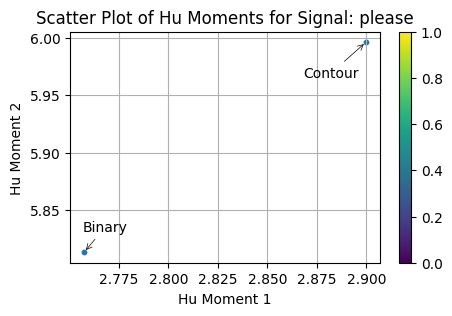

In [9]:
label = y[9][0]

# Create a scatter plot of the first two Hu moments
plt.figure(figsize=(5, 3))
scatter = plt.scatter([B_hu_moments[0], C_hu_moments[0]], [B_hu_moments[1], C_hu_moments[1]], cmap='viridis', s=10)
plt.annotate('Binary', (B_hu_moments[0], B_hu_moments[1]), textcoords="offset points", xytext=(15,15), ha='center',arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
plt.annotate('Contour', (C_hu_moments[0], C_hu_moments[1]), textcoords="offset points", xytext=(-25,-25), ha='center',arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add a colorbar to represent the labels (categories)
plt.colorbar(scatter)

# Set plot labels and title
plt.xlabel('Hu Moment 1')
plt.ylabel('Hu Moment 2')
plt.grid()
plt.title(f'Scatter Plot of Hu Moments for Signal: {label}')
plt.show()

As we can see, there is a distinct difference between the two approaches.

For the sake of this document (and to not over-extend too much), we are going to calculate the moments of each of the methods, and compare the mean and variance of all 7 Moments, per category, and we will proceed with the method that yields the better (or not worst) results.

In [10]:
# ! pip install scikit-learn
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

# First Approach: Binary

In [11]:
def calculate_hu_moments_from_binary(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.uint8(gray_image * 255)  # Rescale to 0-255   
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)   
    moments = cv2.moments(binary_image)
    hu_moments = cv2.HuMoments(moments)
    for i in range(0, 7):
        hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))
    return hu_moments.flatten()

def calculate_hu_moments_from_contours(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.uint8(gray_image * 255) 
    _, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(binary_image)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        moments = cv2.moments(mask)
        hu_moments = cv2.HuMoments(moments)
        for i in range(0, 7):
            hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))
        return hu_moments.flatten()
    else:
        return np.zeros(7)  # Return zeros if no contours are found

In [12]:
# Initialize a list to store all Hu moments for all images
all_b_hu_moments = []
all_c_hu_moments = []

# Iterate over the dataset to compute Hu moments for all images
for i in range(X.shape[0]):
    b_hu_moments = calculate_hu_moments_from_binary(X[i])
    c_hu_moments = calculate_hu_moments_from_contours(X[i])
    all_b_hu_moments.append(b_hu_moments)
    all_c_hu_moments.append(c_hu_moments)


# Convert the list of Hu moments to a NumPy array for easy handling
all_b_hu_moments = np.array(all_b_hu_moments)  # Shape: (num_images, 7)
all_c_hu_moments = np.array(all_c_hu_moments)  # Shape: (num_images, 7)

/home/coder/tmp/ipykernel_19884/1363391124.py:23: RuntimeWarning: divide by zero encountered in log10
  hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))
/home/coder/tmp/ipykernel_19884/1363391124.py:23: RuntimeWarning: invalid value encountered in multiply
  hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))


In [13]:
df = pd.DataFrame(y, columns=['Label'])
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)  # Encode word labels into integer labels
df['Encoded Label'] = encoded_labels
b_hu_df = pd.DataFrame(all_b_hu_moments, columns=[f'B_Hu_{i+1}' for i in range(all_b_hu_moments.shape[1])])
c_hu_df = pd.DataFrame(all_c_hu_moments, columns=[f'C_Hu_{i+1}' for i in range(all_c_hu_moments.shape[1])])
df = pd.concat([df.reset_index(drop=True), b_hu_df.reset_index(drop=True)], axis=1)
df = pd.concat([df.reset_index(drop=True), c_hu_df.reset_index(drop=True)], axis=1)
df_grouped = df.groupby(by = ['Label','Encoded Label']).agg(['mean','std'])

/home/coder/.local/lib/rolos-ml/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
import matplotlib.pyplot as plt

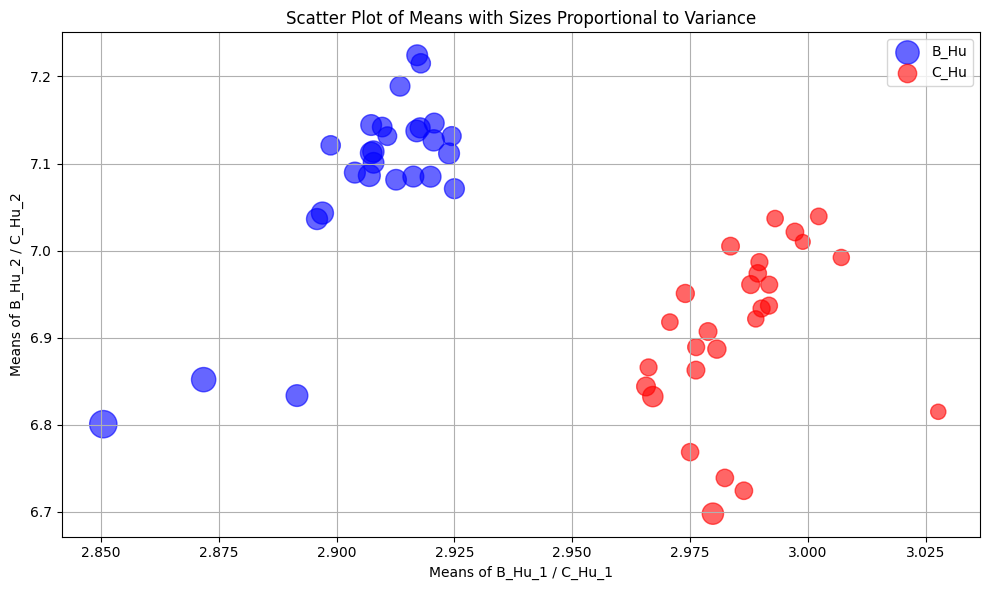

In [15]:
means = df_grouped.xs('mean', level=1, axis=1)  # Get mean values
stds = df_grouped.xs('std', level=1, axis=1)    # Get standard deviation values

# Step 2: Select the relevant columns
columns_of_interest = ['B_Hu_1', 'B_Hu_2', 'C_Hu_1', 'C_Hu_2']
means_selected = means[columns_of_interest]
stds_selected = stds[columns_of_interest]

# Step 3: Calculate variances
variances = stds_selected ** 2

# Prepare scatter plot
plt.figure(figsize=(10, 6))

scaling_var = 10000
# Scatter plot for B_Hu_1 vs B_Hu_2
plt.scatter(means_selected['B_Hu_1'], means_selected['B_Hu_2'], 
            s=variances['B_Hu_1'] * scaling_var,  # Scale variance for better visibility
            alpha=0.6, label='B_Hu', color='blue')

# Scatter plot for C_Hu_1 vs C_Hu_2
plt.scatter(means_selected['C_Hu_1'], means_selected['C_Hu_2'], 
            s=variances['C_Hu_1'] * scaling_var,  # Scale variance for better visibility
            alpha=0.6, label='C_Hu', color='red')

# Adding labels and title
plt.xlabel('Means of B_Hu_1 / C_Hu_1')
plt.ylabel('Means of B_Hu_2 / C_Hu_2')
plt.title('Scatter Plot of Means with Sizes Proportional to Variance')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

From the result above, we can see that the Contours even though as a total are more joined together, there averages are not overlapping as much as the binary method.

So, we are going to stick with the contours for now, but it could be nice to see what yields the binary also.

## Visualization of the Hu's Moments for Contours.

We will add a value "n", to choose a lesser value of images to visualize, because plotting them all might be too much.

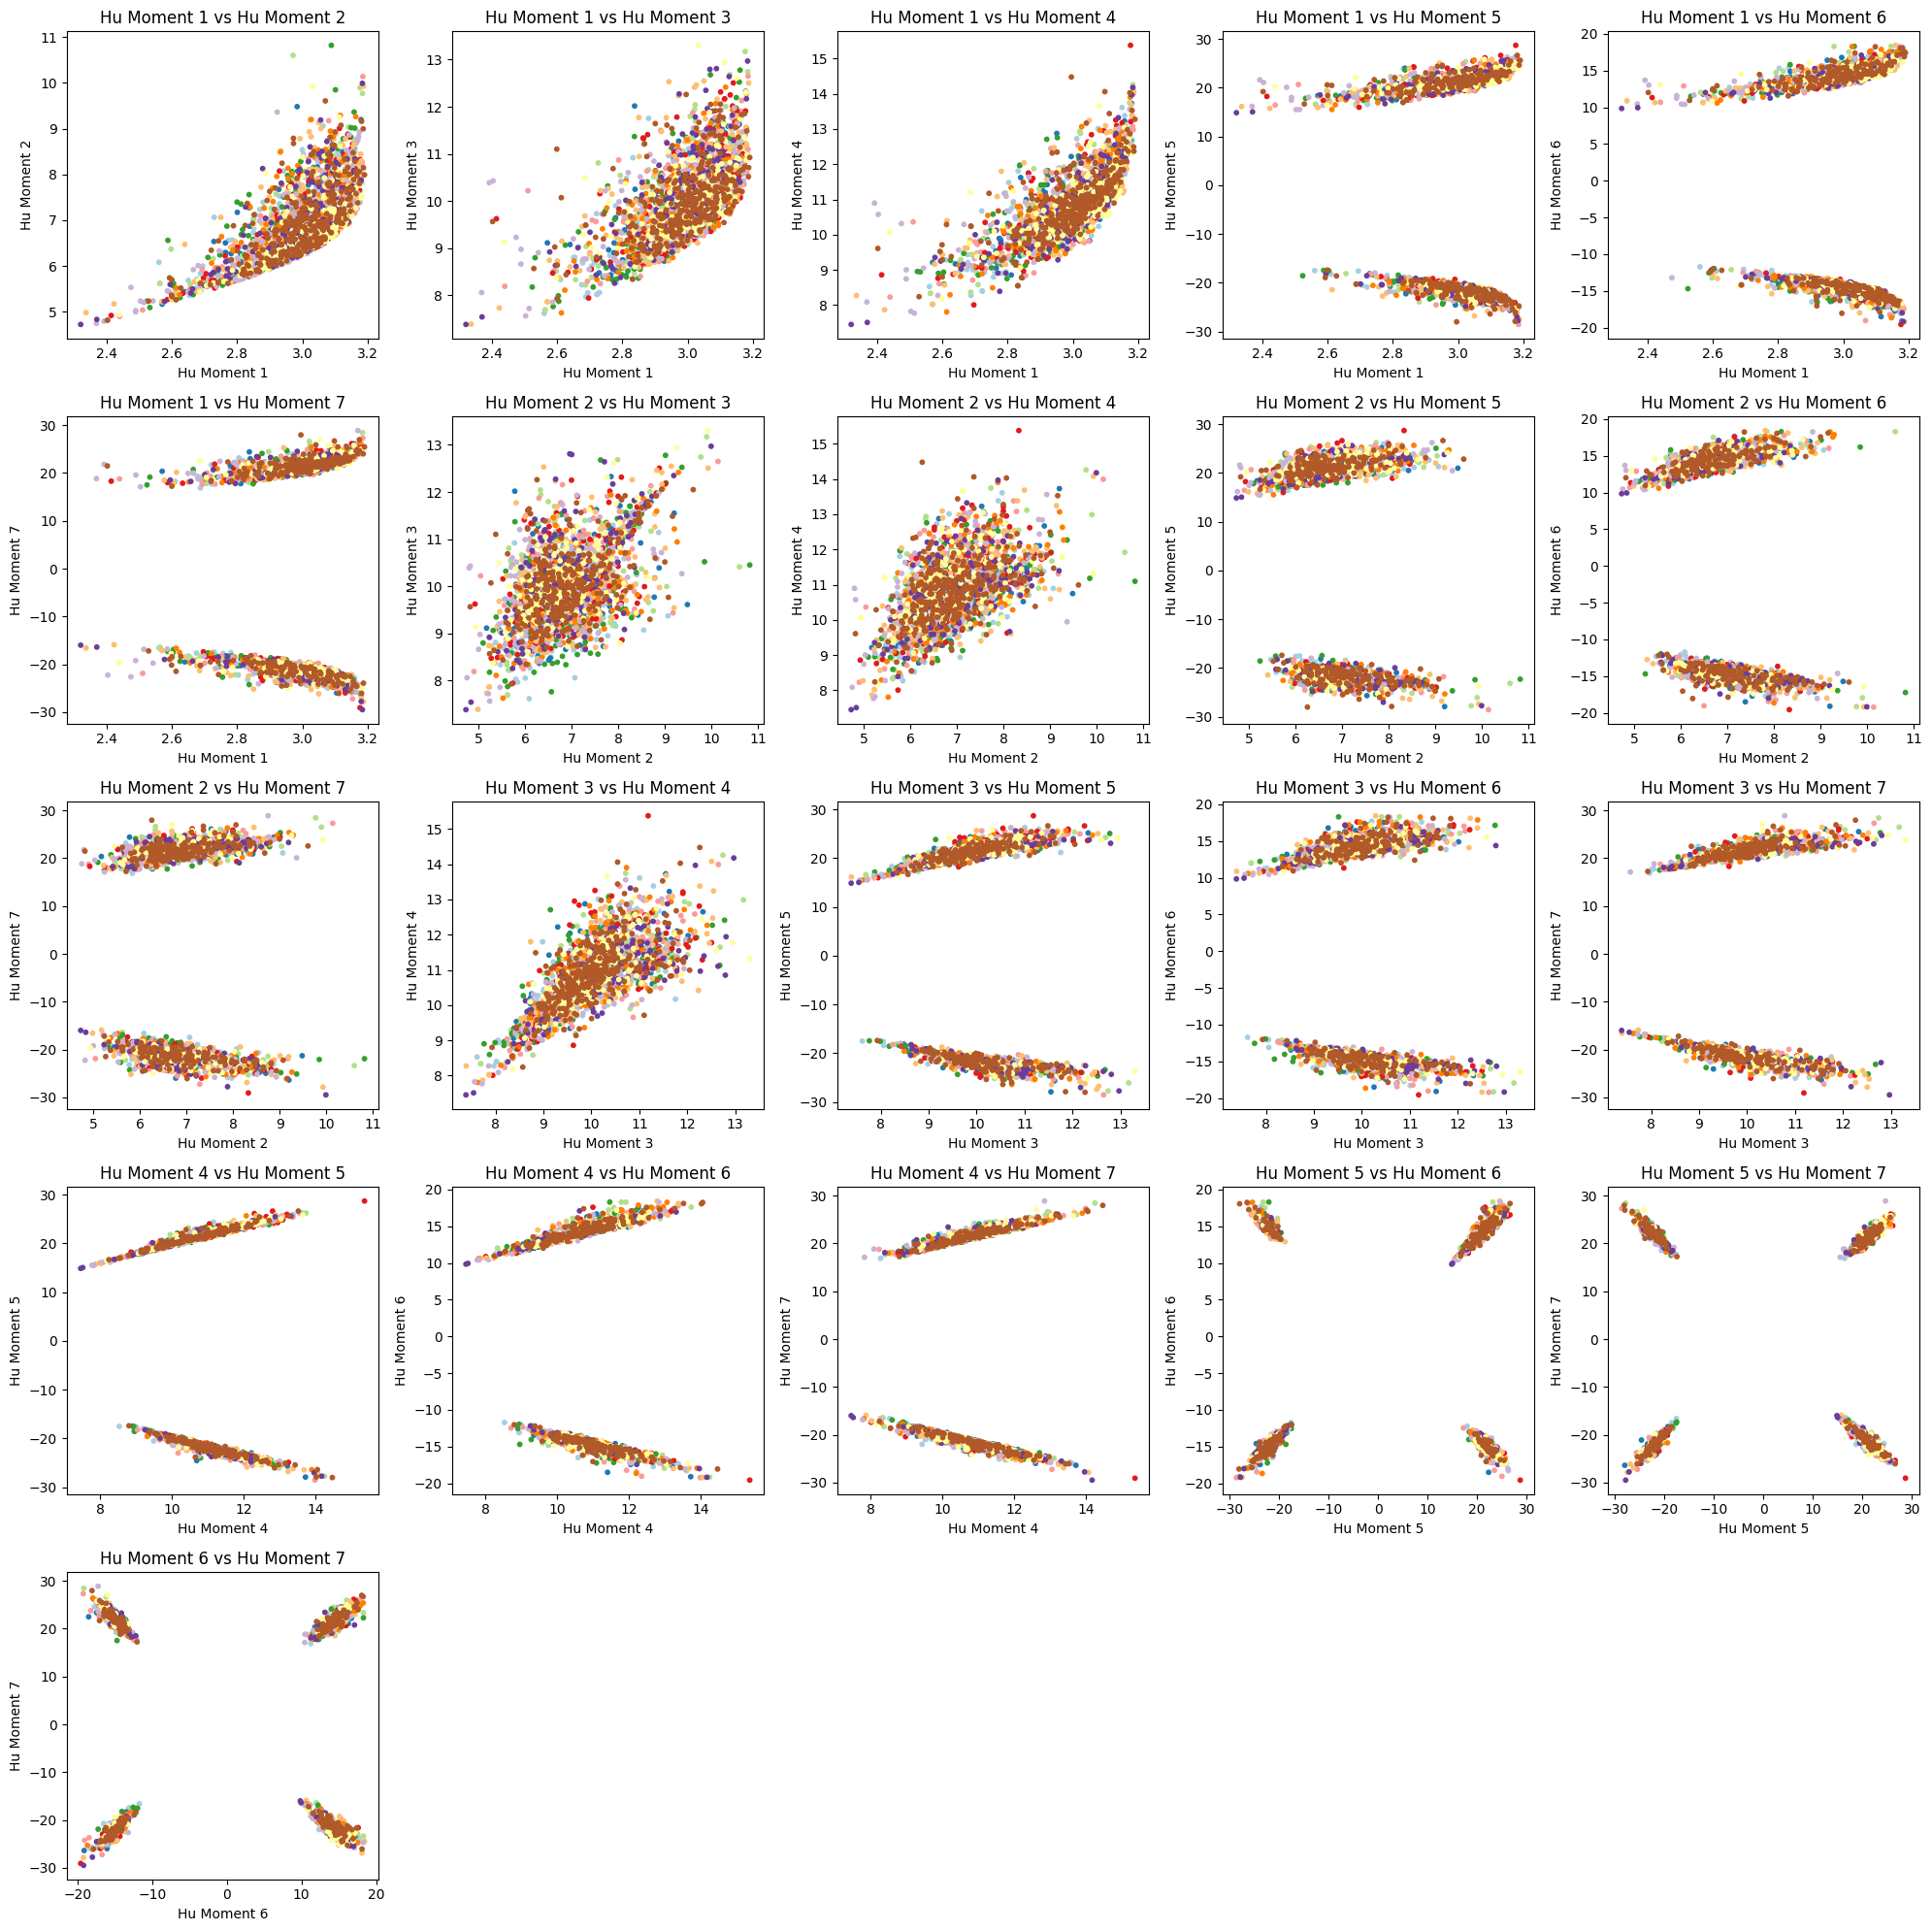

In [16]:
selected_images = []
selected_labels = []

n = 100

for label in np.unique(encoded_labels):
    indices = np.where(encoded_labels == label)[0]
    selected_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    
    selected_images.append(X[selected_indices])
    selected_labels.append(encoded_labels[selected_indices])

selected_images = np.concatenate(selected_images, axis=0)
selected_labels = np.concatenate(selected_labels, axis=0)

selected_hu_moments = []

for i in range(selected_images.shape[0]):
    hu_moments = calculate_hu_moments_from_contours(selected_images[i])
    selected_hu_moments.append(hu_moments)

selected_hu_moments = np.array(selected_hu_moments)  

pairs_of_hu_moments = list(combinations(range(7), 2))  # This gives all pairs (0,1), (0,2), ..., (5,6)

# Create subplots (a grid, e.g., 5x5 grid to handle 21 pairs)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten axs for easy indexing
axs = axs.ravel()

# Iterate over the pairs and plot scatter plots
for i, (hu_x, hu_y) in enumerate(pairs_of_hu_moments):
    axs[i].scatter(selected_hu_moments[:, hu_x], selected_hu_moments[:, hu_y], c=selected_labels, cmap='Paired', s=10)
    axs[i].set_xlabel(f'Hu Moment {hu_x + 1}')
    axs[i].set_ylabel(f'Hu Moment {hu_y + 1}')
    axs[i].set_title(f'Hu Moment {hu_x + 1} vs Hu Moment {hu_y + 1}')

# Remove any extra subplots if necessary
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

As we can see, the images seem to be scattered in such a way that there is no distinct clusters forming with respect to (any) Hu moment.

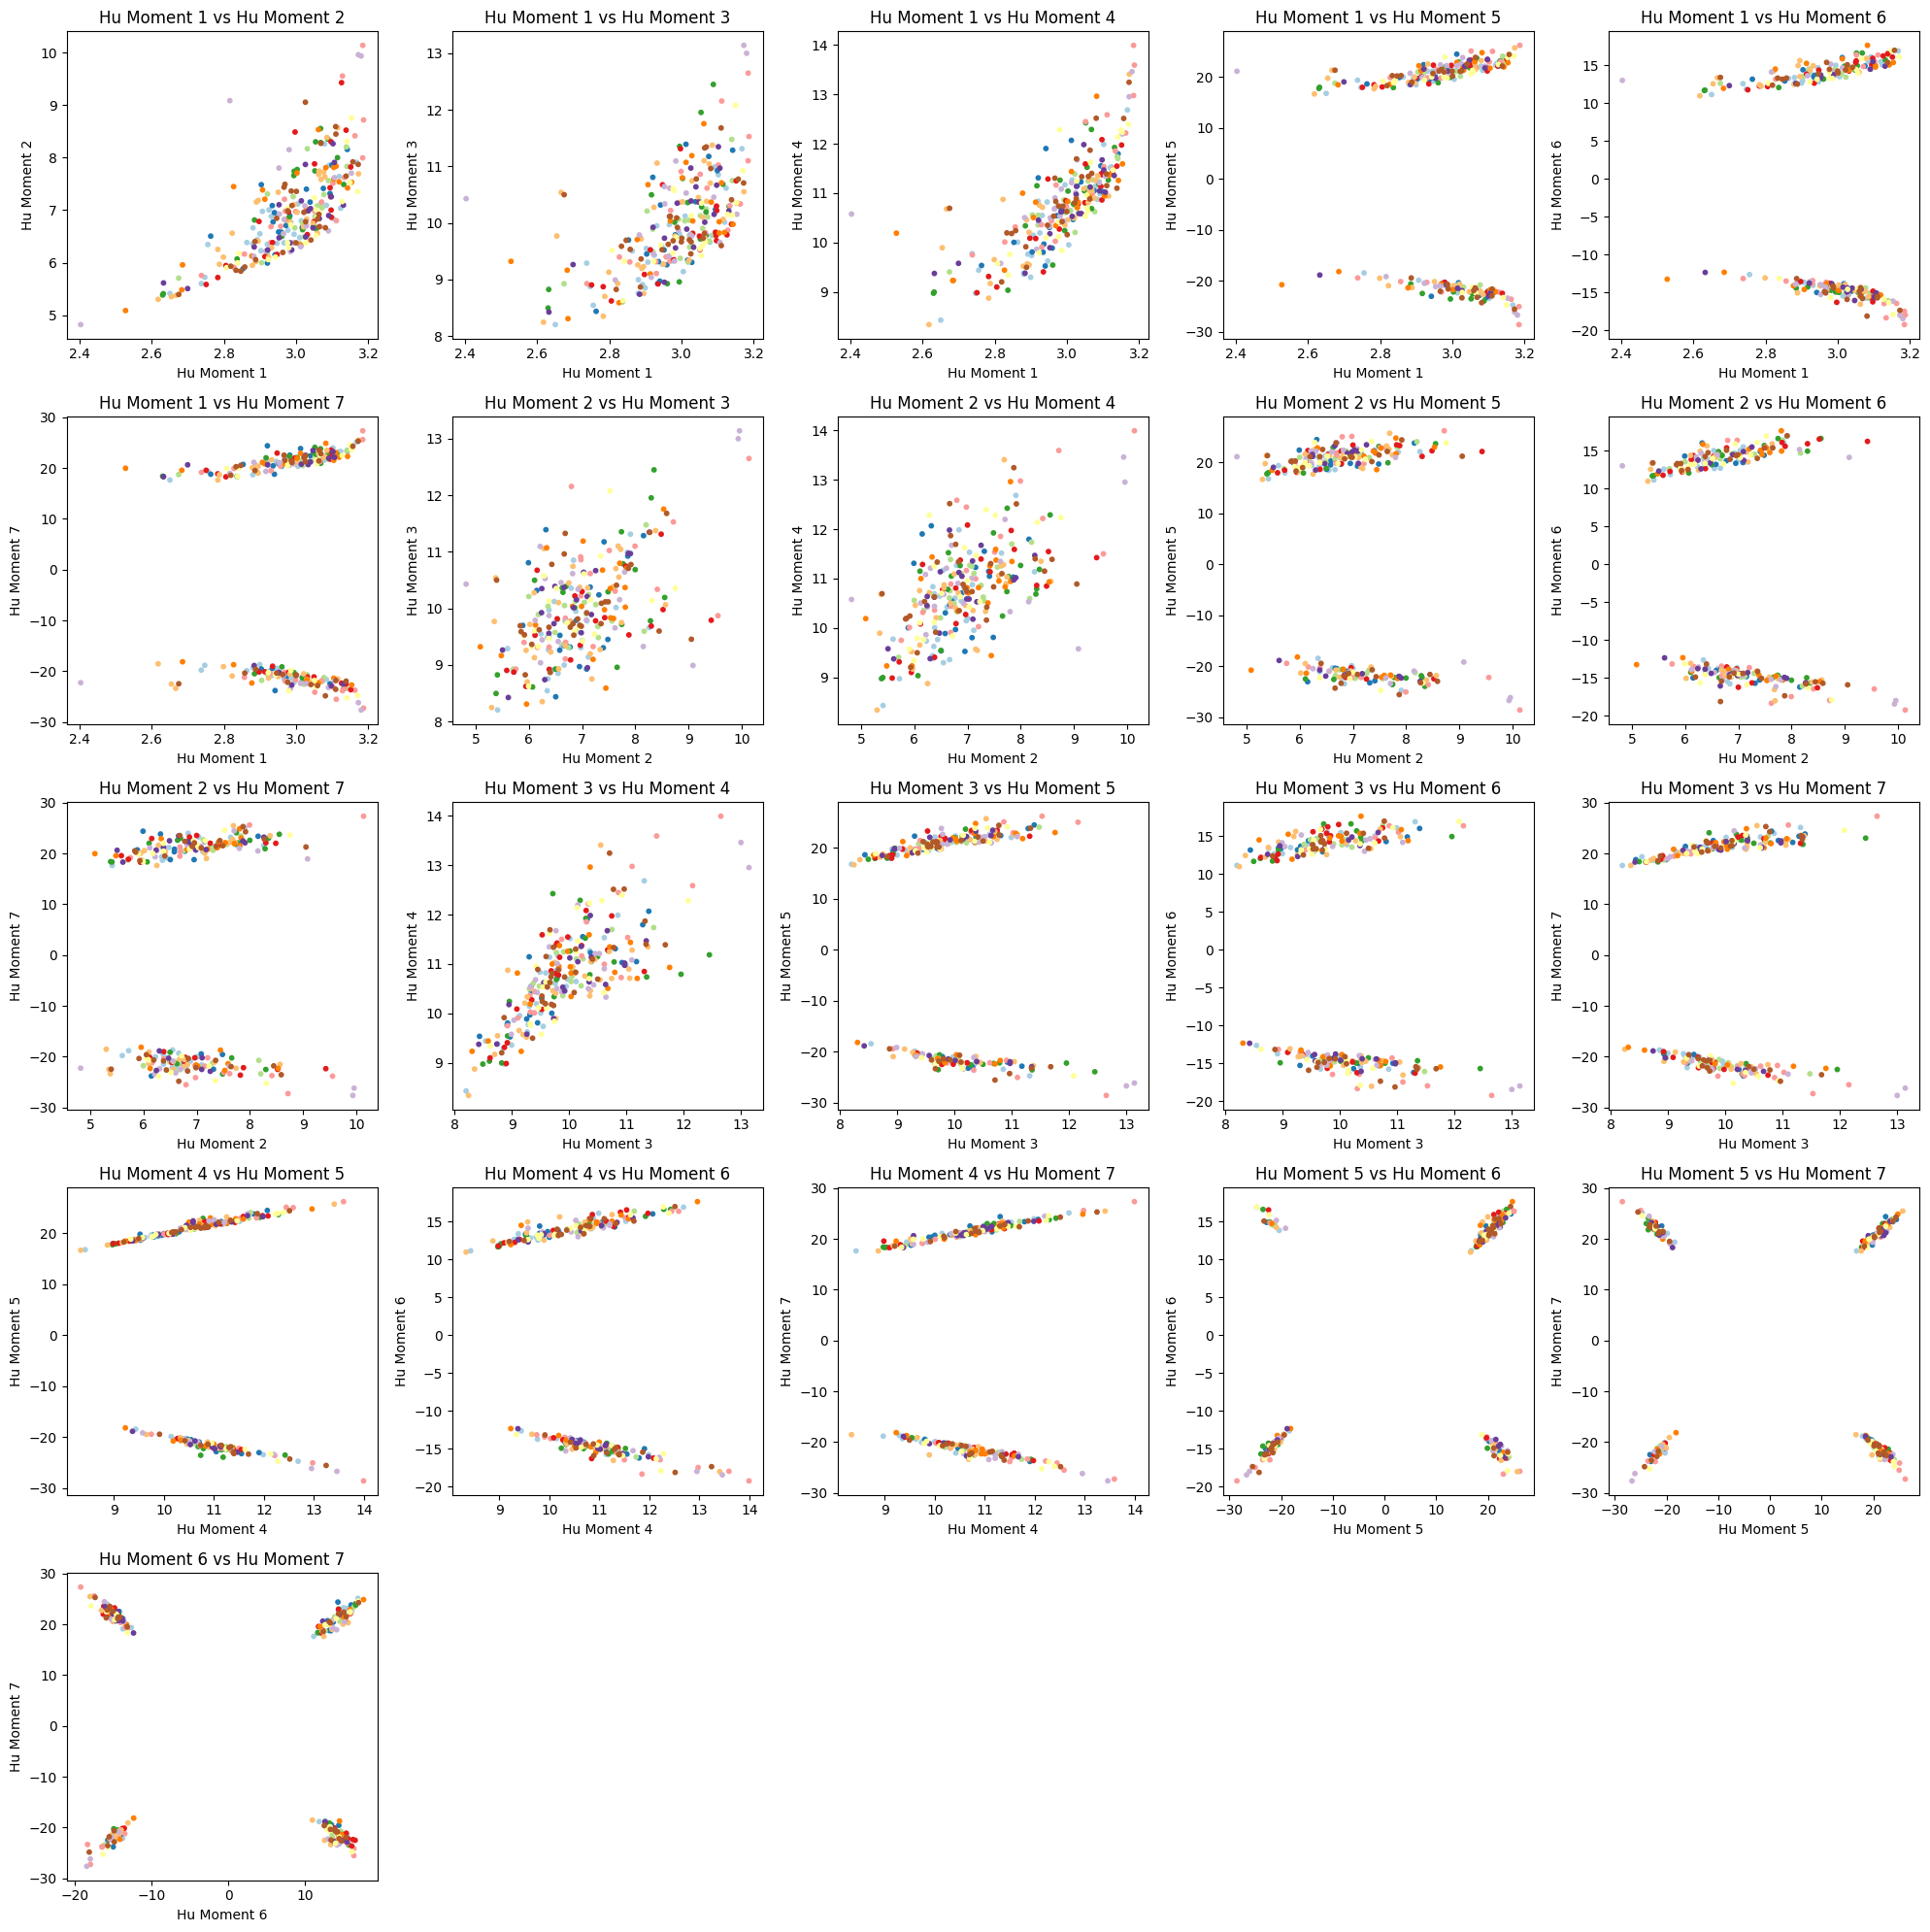

In [17]:
selected_images = []
selected_labels = []

n = 10

for label in np.unique(encoded_labels):
    indices = np.where(encoded_labels == label)[0]
    selected_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    
    selected_images.append(X[selected_indices])
    selected_labels.append(encoded_labels[selected_indices])

selected_images = np.concatenate(selected_images, axis=0)
selected_labels = np.concatenate(selected_labels, axis=0)

selected_hu_moments = []

for i in range(selected_images.shape[0]):
    hu_moments = calculate_hu_moments_from_contours(selected_images[i])
    selected_hu_moments.append(hu_moments)

selected_hu_moments = np.array(selected_hu_moments)  

pairs_of_hu_moments = list(combinations(range(7), 2))  # This gives all pairs (0,1), (0,2), ..., (5,6)

# Create subplots (a grid, e.g., 5x5 grid to handle 21 pairs)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten axs for easy indexing
axs = axs.ravel()

# Iterate over the pairs and plot scatter plots
for i, (hu_x, hu_y) in enumerate(pairs_of_hu_moments):
    axs[i].scatter(selected_hu_moments[:, hu_x], selected_hu_moments[:, hu_y], c=selected_labels, cmap='Paired', s=10)
    axs[i].set_xlabel(f'Hu Moment {hu_x + 1}')
    axs[i].set_ylabel(f'Hu Moment {hu_y + 1}')
    axs[i].set_title(f'Hu Moment {hu_x + 1} vs Hu Moment {hu_y + 1}')

# Remove any extra subplots if necessary
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Reducing n from 100 to 10 does not seem to help, as the distribution of all the categories seems very homogeneous.

We will visualize the Hu Moments of a single class, and see how spread are they.

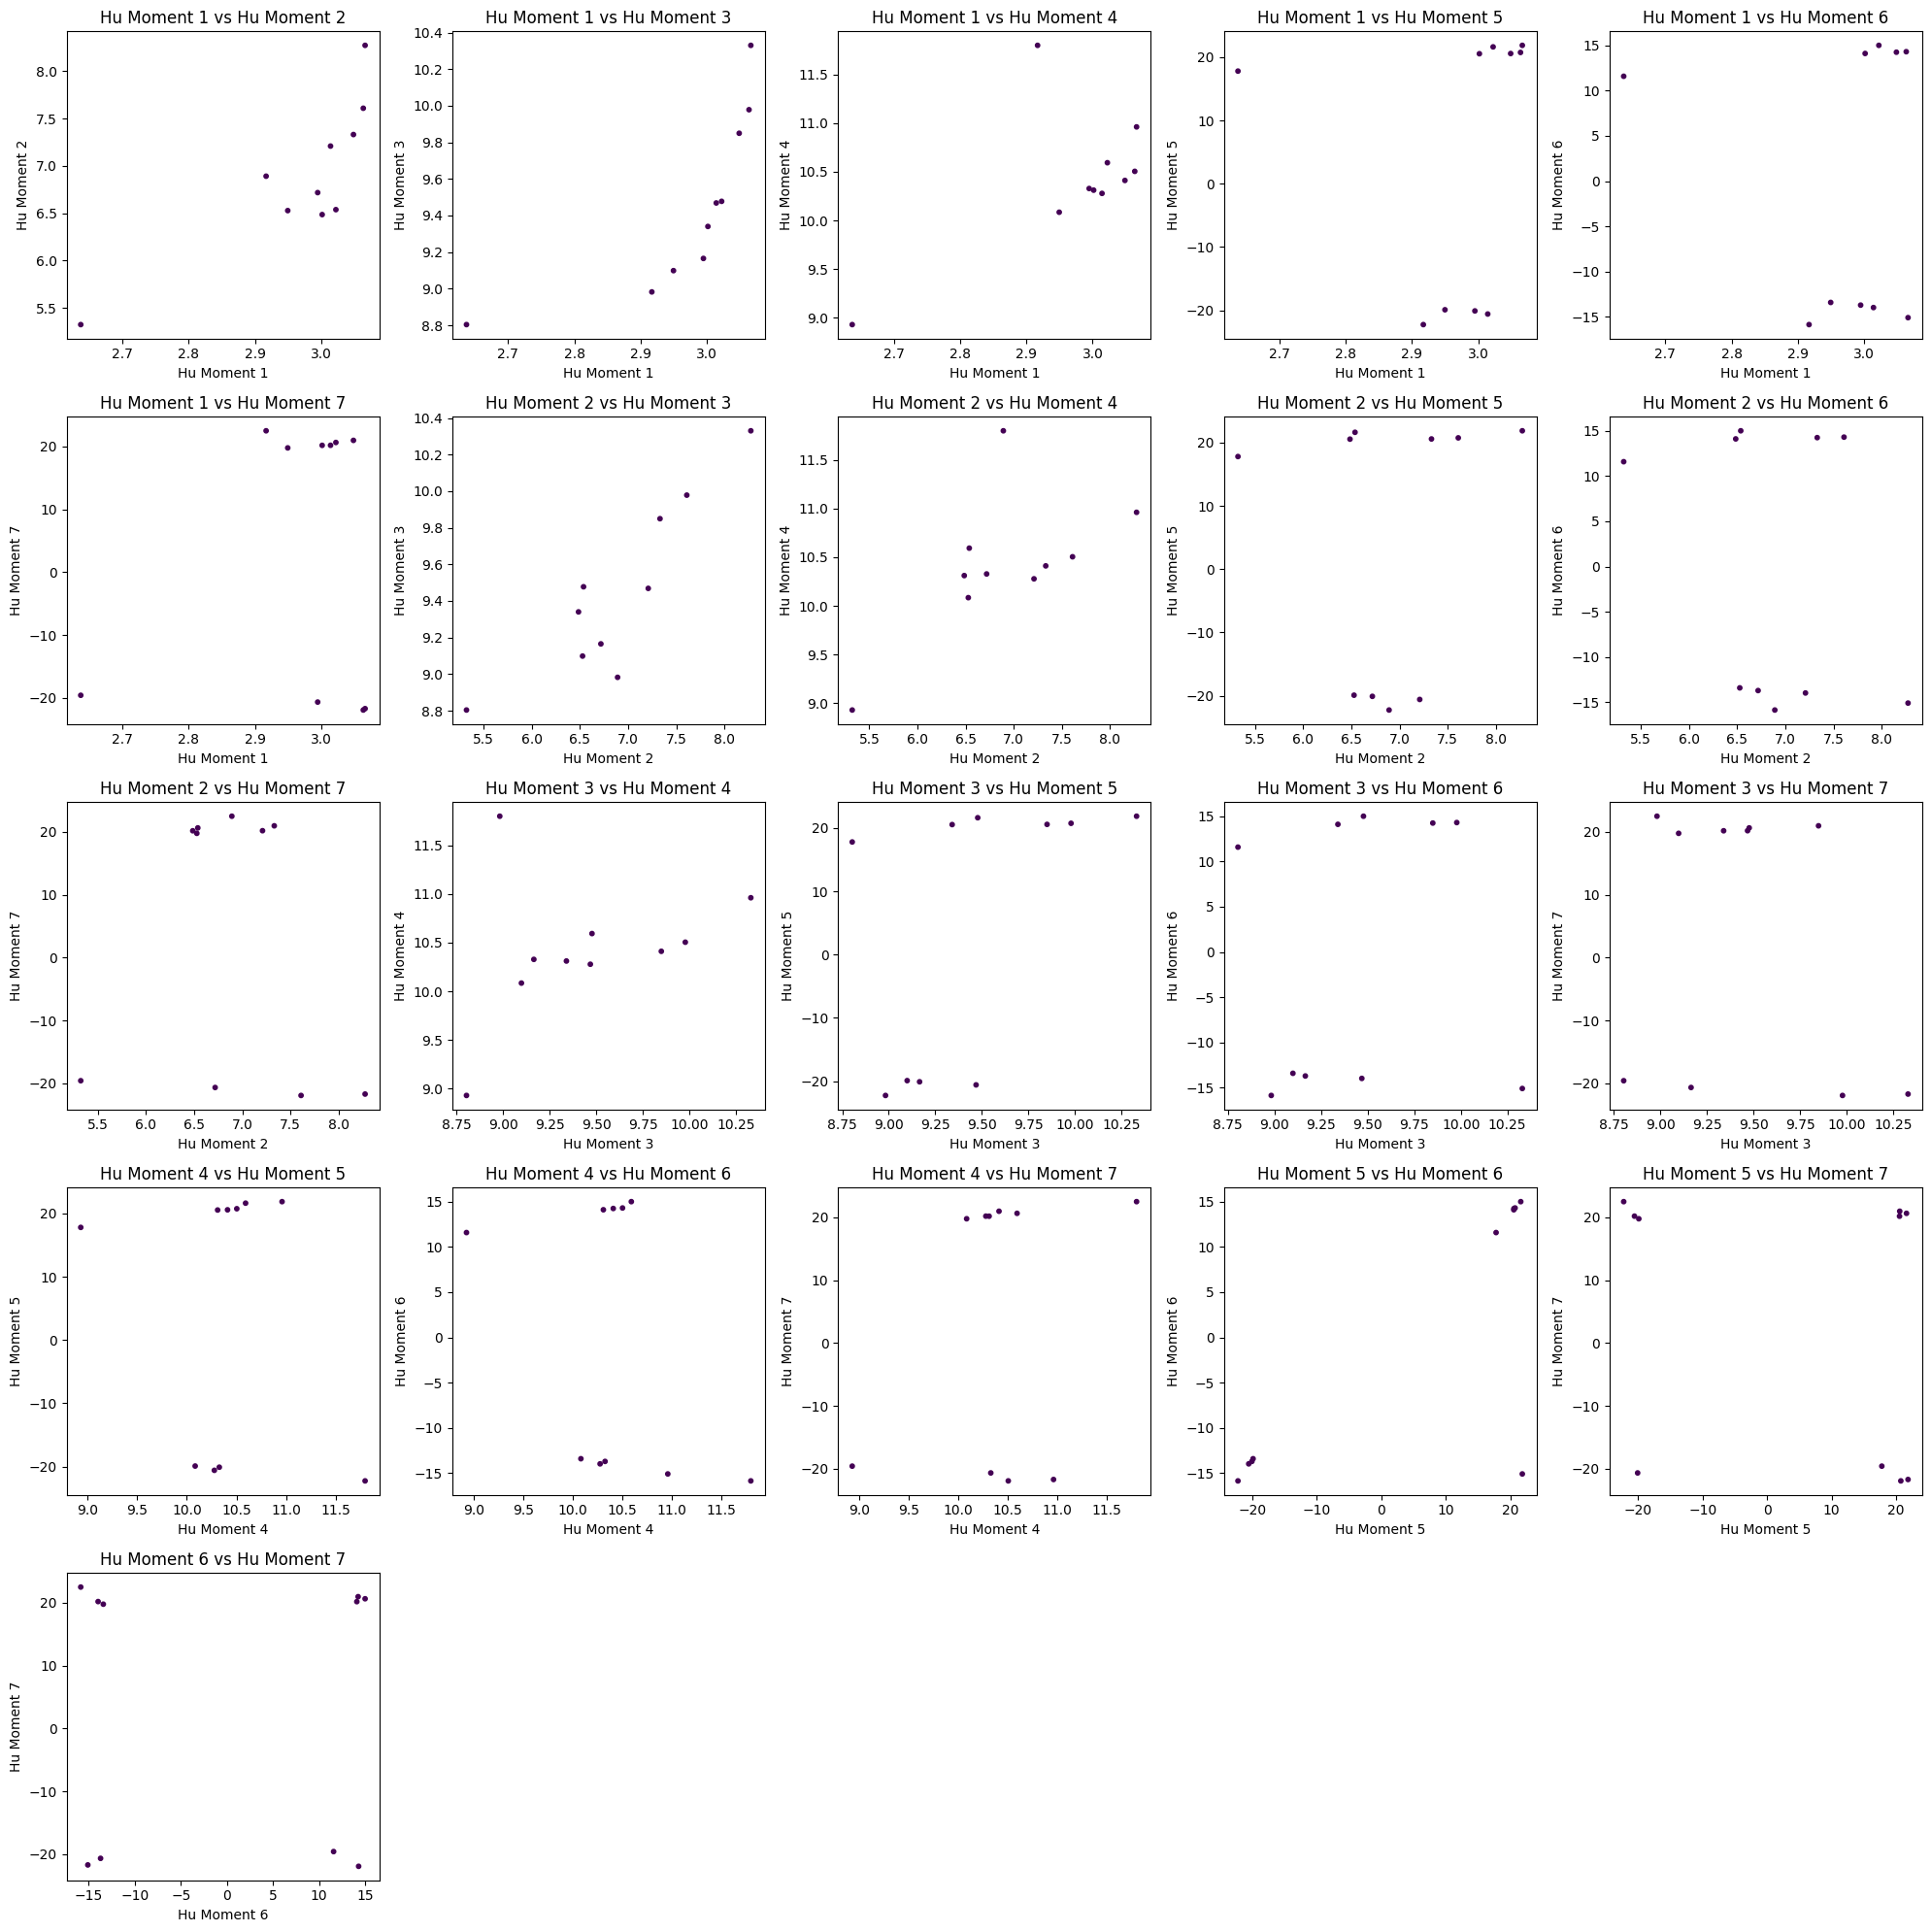

In [18]:
selected_images = []
selected_labels = []

for label in [np.unique(encoded_labels)[0]]:
    indices = np.where(encoded_labels == label)[0]
    selected_indices = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    
    selected_images.append(X[selected_indices])
    selected_labels.append(encoded_labels[selected_indices])

selected_images = np.concatenate(selected_images, axis=0)
selected_labels = np.concatenate(selected_labels, axis=0)

selected_hu_moments = []

for i in range(selected_images.shape[0]):
    hu_moments = calculate_hu_moments_from_contours(selected_images[i])
    selected_hu_moments.append(hu_moments)

selected_hu_moments = np.array(selected_hu_moments)  

pairs_of_hu_moments = list(combinations(range(7), 2))  # This gives all pairs (0,1), (0,2), ..., (5,6)

# Create subplots (a grid, e.g., 5x5 grid to handle 21 pairs)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten axs for easy indexing
axs = axs.ravel()

# Iterate over the pairs and plot scatter plots
for i, (hu_x, hu_y) in enumerate(pairs_of_hu_moments):
    axs[i].scatter(selected_hu_moments[:, hu_x], selected_hu_moments[:, hu_y], c=selected_labels, cmap='viridis', s=10)
    axs[i].set_xlabel(f'Hu Moment {hu_x + 1}')
    axs[i].set_ylabel(f'Hu Moment {hu_y + 1}')
    axs[i].set_title(f'Hu Moment {hu_x + 1} vs Hu Moment {hu_y + 1}')

# Remove any extra subplots if necessary
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

As we can see, for a particular class, all the moments seem to bee occupying all the possible areas.

# PCA Analysis

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [20]:
df = pd.DataFrame(all_c_hu_moments, columns=['Hu_1', 'Hu_2', 'Hu_3', 'Hu_4', 'Hu_5', 'Hu_6', 'Hu_7'])

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)  # Encode word labels into integer labels
df['Signal'] = encoded_labels
# print(df.info())
df_cleaned = df.dropna()
# print(df_cleaned.info())
original_index = df.index.tolist()
cleaned_index = df_cleaned.index.tolist()
dropped_indexes = list(set(original_index) - set(cleaned_index))
dropped_indexes = np.array(dropped_indexes)
# X_cleaned = np.delete(X, dropped_indexes, axis=0)
# y_cleaned = np.delete(y, dropped_indexes, axis=0)

it.: 2
it.: 3
it.: 4
it.: 5
it.: 6
it.: 7
it.: 8
it.: 9
it.: 10
it.: 11
it.: 12
it.: 13


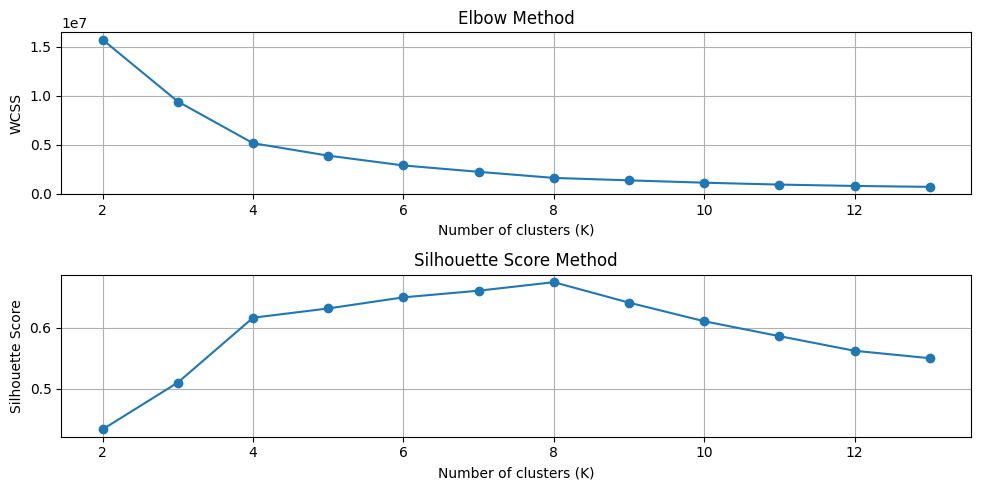

In [21]:
# Assuming df contains your preprocessed features dataframe
# Range of K values to try
k_values = range(2, 14)
# WCSS values
wcss = []
# Silhouette scores
silhouette_scores = []
for k in k_values:
    print(f"it.: {k}")
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cleaned)
    wcss.append(kmeans.inertia_) # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(df_cleaned, kmeans.labels_))
# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1) #number of rows, number of columns, specific plot we refer to
plt.grid()
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
# Plot Silhouette Score
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.tight_layout()
plt.show()

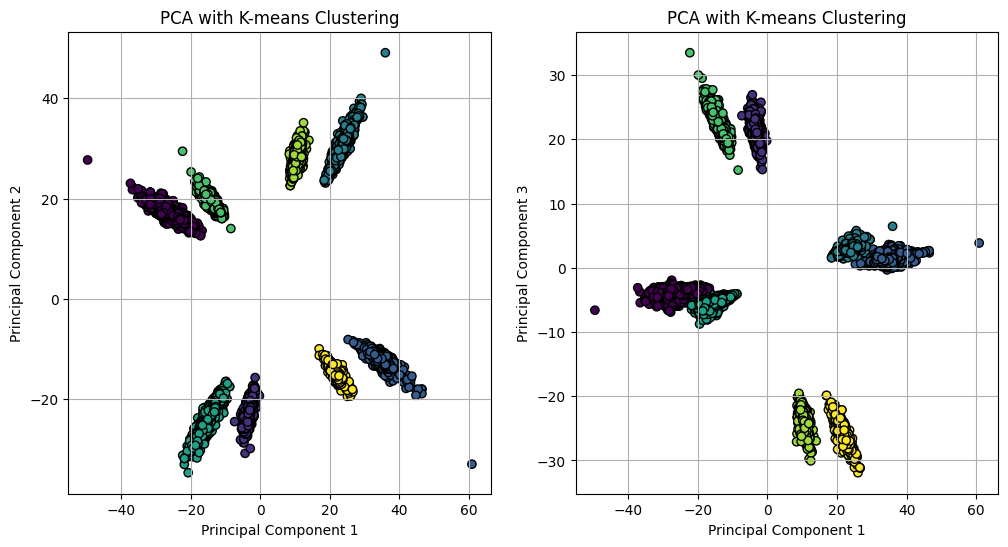

In [22]:
# Perform PCA
pca = PCA(n_components=3) # Specify the number of components you want to keep
X_pca = pca.fit_transform(df_cleaned)
# Choose the number of clusters (you can use methods like elbow plot)
num_clusters = 8
# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_pca)
labels = kmeans.labels_
# Visualize the clusters
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[0].set_title('PCA with K-means Clustering')
axs[0].grid(True)
axs[1].scatter(X_pca[:, 0], X_pca[:, 2], c=labels, cmap='viridis', edgecolor='k')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 3')
axs[1].set_title('PCA with K-means Clustering')
axs[1].grid(True)
plt.show()

Seems that we have 8 clear clusters.

In [23]:
df_with_clusters = df_cleaned.copy()
df_with_clusters['Cluster'] = labels

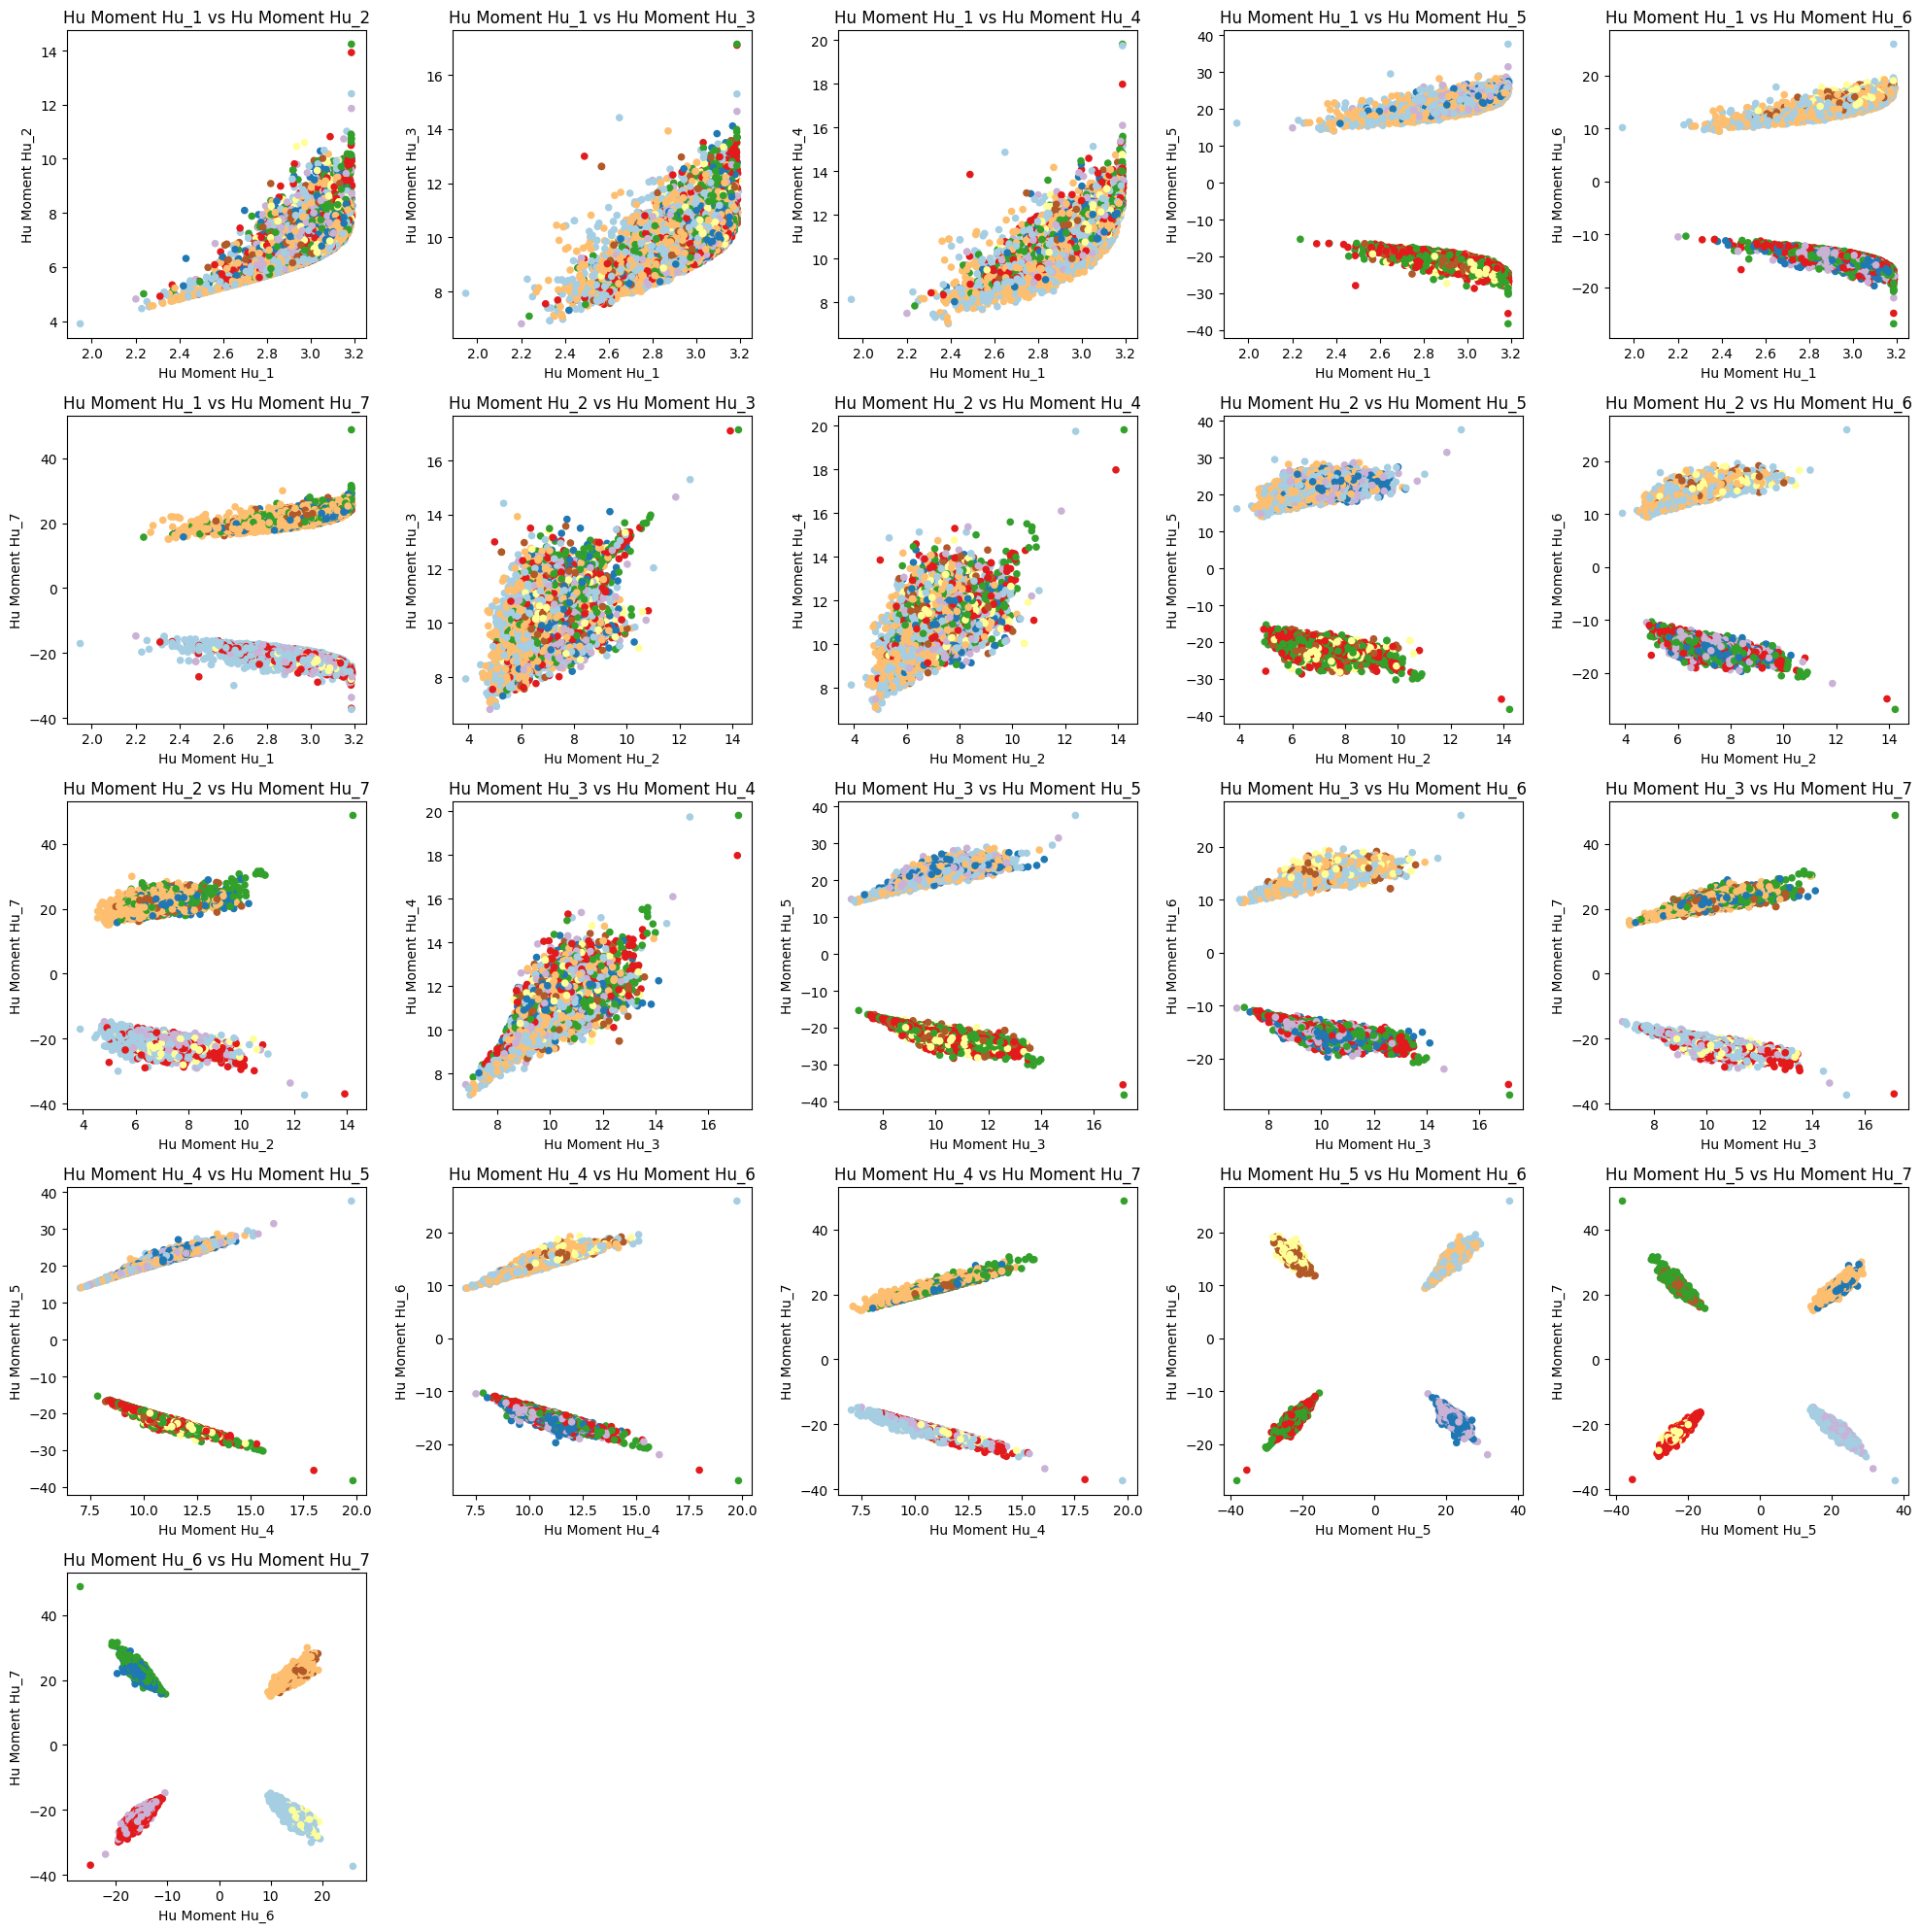

In [24]:
words = ['Hu_1', 'Hu_2', 'Hu_3', 'Hu_4', 'Hu_5', 'Hu_6', 'Hu_7']
combos = list(combinations(words, 2))

# Create subplots (a grid, e.g., 5x5 grid to handle 21 pairs)
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

# Flatten axs for easy indexing
axs = axs.ravel()

# Iterate over the pairs and plot scatter plots
for i, (hu_x, hu_y) in enumerate(combos):
    axs[i].scatter(df_with_clusters[hu_x], df_with_clusters[hu_y], c=df_with_clusters['Cluster'], cmap='Paired', s=20)
    axs[i].set_xlabel(f'Hu Moment {hu_x}')
    axs[i].set_ylabel(f'Hu Moment {hu_y}')
    axs[i].set_title(f'Hu Moment {hu_x} vs Hu Moment {hu_y}')

# Remove any extra subplots if necessary
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

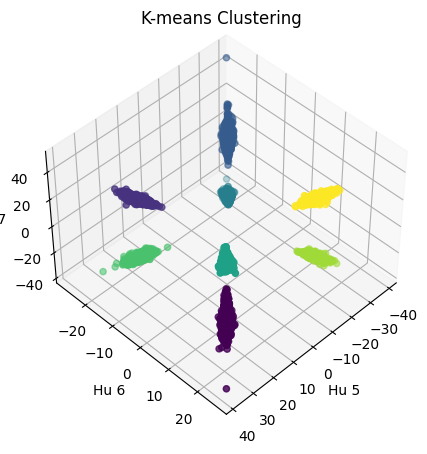

In [25]:
# Plot clusters
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_cleaned["Hu_5"], df_cleaned["Hu_6"], df_cleaned["Hu_7"], c=labels, cmap='viridis', marker="o")
ax.set_title('K-means Clustering')
ax.set_xlabel('Hu 5')
ax.set_ylabel('Hu 6')
ax.set_zlabel('Hu 7')
ax.grid(True)
ax.view_init(elev=45, azim=45) # Set the elevation and azimuth angles
plt.show()

# Conclusions:

Seems that the method of Moment Invariants of an image is not a valuable approach when it comes to analyzing the hand language dataset. 

And it makes sense. The analysis made by Hu et.al on the paper, was made on rather simple and yet very distinct characters from one another (numbers and the alphabet). And yet those characters had moment invariants that could easily overlap.

In the case of our dataset, the fact that all the "characters" are made by hands (so they have some sort of "same starting point"), and some of the classes resemble a lot between each other (besides some specific rotation, or where the hand is positioned with respect the body), makes more understandable the fact that the moment invariants are quite similar. This is even more important, considering the fact that the moment invariants consider invariancy against rotation, which actually can make two very distinct language signals in terms of meaning, almost identical in terms of invariant values.

Applying cluster analysis over the PCA of the moments, we could find 8 distinct clusters according to the elbow and silhouette methods, which are related to the moments 5, 6, and 7. It could be usefull to determine which signals belong to which cluster.

Regardless of the previous point, something stated before is that it is crucial for the signal not the symbol displayed by the hand per se, but also where it is positioned with respect to the body. So in our specific case, the **background is important**.